<a href="https://colab.research.google.com/github/ChintzRuparel/Stock-Market-Prediction-Using-LSTM/blob/main/HDFCBANK_Historical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 10.0)

: 

### data set reading

In [67]:
df = pd.read_csv('HDFCBANK.csv') ##Source File to be changed here
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,02/1/1996,2.975,412000,2.980,3.025,2.95
1,03/1/1996,2.985,284000,2.975,2.995,2.95
2,04/1/1996,2.965,282000,2.985,2.980,2.94
3,05/1/1996,2.960,189000,2.965,2.980,2.95
4,08/1/1996,2.925,237000,2.960,2.950,2.91


### preprocessing data set to perform analysis

In [68]:
df.shape

(6673, 6)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6673 entries, 0 to 6672
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        6673 non-null   object 
 1   Close/Last  6673 non-null   float64
 2   Volume      6673 non-null   int64  
 3   Open        6673 non-null   float64
 4   High        6673 non-null   float64
 5   Low         6673 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 312.9+ KB


In [70]:
df1 = df.iloc[:,1]
df1.head()

0    2.975
1    2.985
2    2.965
3    2.960
4    2.925
Name: Close/Last, dtype: float64

In [71]:
df1.tail()

6668    1355.650024
6669    1352.599976
6670    1371.250000
6671    1395.800049
6672    1397.099976
Name: Close/Last, dtype: float64

In [72]:
df1 = df1.replace('[\$,]', '', regex=True).astype(float)
df1.head()

0    2.975
1    2.985
2    2.965
3    2.960
4    2.925
Name: Close/Last, dtype: float64

Text(0, 0.5, 'stock price')

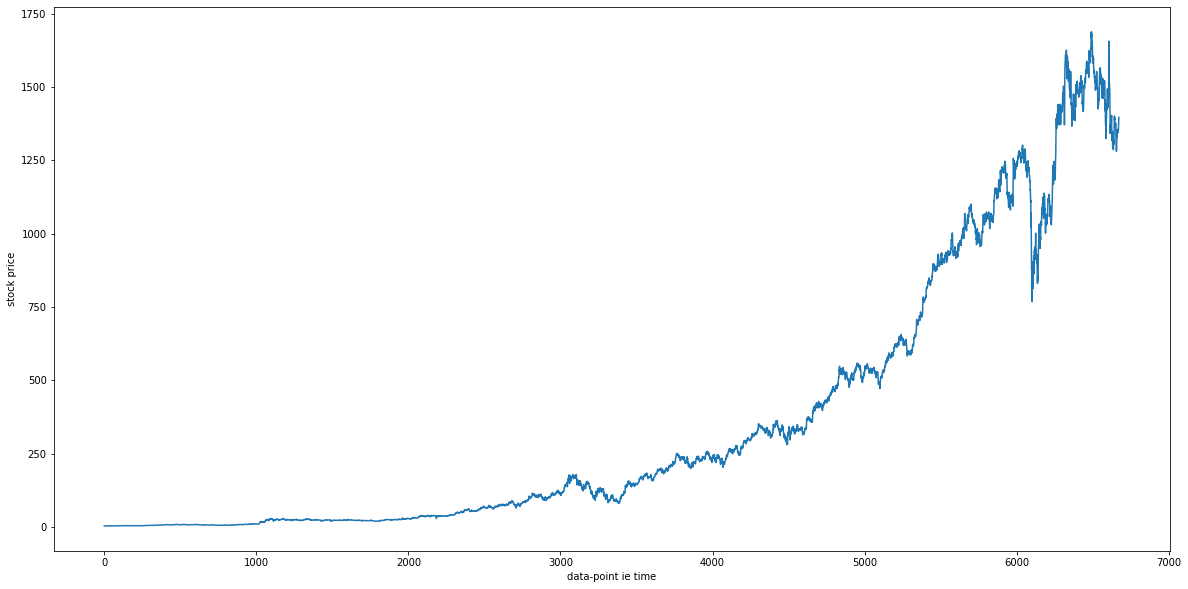

In [73]:
plt.plot(df1)
plt.xlabel("data-point ie time")
plt.ylabel("stock price")

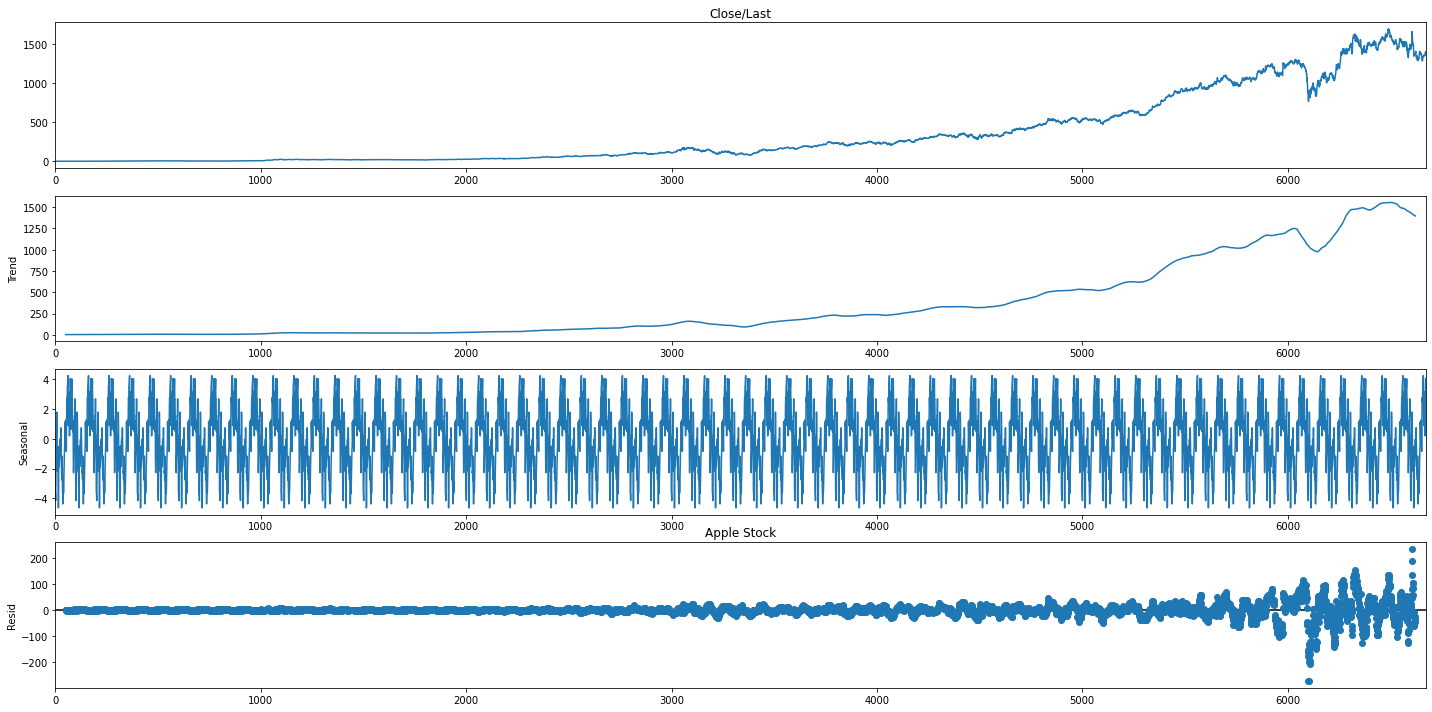

In [74]:
#show the components of this time series
from statsmodels.tsa.seasonal import seasonal_decompose

result  = seasonal_decompose(pd.Series(df1),period=100)

result.plot()
plt.title('Apple Stock')
plt.show()

In [75]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

In [76]:
df1.shape

(6673,)

In [77]:
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [78]:
print(df1)
print('\n df1 present shape : ', df1.shape)

[[3.20234373e-04]
 [3.26164640e-04]
 [3.14304107e-04]
 ...
 [8.11743729e-01]
 [8.26302562e-01]
 [8.27073453e-01]]

 df1 present shape :  (6673, 1)


### splitting data (70/30)

In [79]:
training_size = int(len(df1)*0.7)
test_size = len(df1) - training_size
print('Training Size : ',training_size)
print('Test Size : ',test_size)

Training Size :  4671
Test Size :  2002


In [80]:
train_data, test_data = df1[0:training_size,:],df1[training_size:len(df1),:]
print('Training Data Shape : ', train_data.shape)
print('Test Data Shape: ', test_data.shape)

Training Data Shape :  (4671, 1)
Test Data Shape:  (2002, 1)


### | windowing data set |

In [81]:
def create_dataset(dataset, window=1):
    dataX, dataY= [], []
    for i in range(len(dataset)-window-1):
        a = dataset[i:(i+window),0]
        dataX.append(a)
        dataY.append(dataset[i+window,0])
    return np.array(dataX), np.array(dataY)

In [82]:
window = 100
X_train, y_train = create_dataset(train_data, window=100)
X_test, y_test = create_dataset(test_data, window=100)

In [83]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4570, 100) (4570,)
(1901, 100) (1901,)


In [84]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

### lstm coding

In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [86]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer = 'adam')

In [87]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


### fitting data to model

In [88]:
model.fit(X_train,y_train,validation_data = (X_test,y_test), epochs = 2, batch_size=64,verbose=1)

Epoch 1/2
72/72 [==============================] - 20s 202ms/step - loss: 3.3299e-04 - val_loss: 0.0028
Epoch 2/2
72/72 [==============================] - 13s 182ms/step - loss: 1.8808e-05 - val_loss: 0.0044


In [89]:
y_pred = scaler.inverse_transform(model.predict(X_test))

60/60 [==============================] - 3s 33ms/step


In [90]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [91]:
y_pred[:5]

array([[437.1778 ],
       [437.99182],
       [438.87408],
       [439.78403],
       [440.71094]], dtype=float32)

In [92]:
y_test[:5]

array([[448.625   ],
       [447.649994],
       [445.774994],
       [448.325012],
       [455.924988]])

### evaluation

In [93]:
import math
from sklearn.metrics import mean_squared_error

rmse_score = math.sqrt(mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error(test) : ',rmse_score)

Root Mean Squared Error(test) :  111.7362516695586


In [94]:
from sklearn.metrics import r2_score
print('R-squared Score  : ',r2_score(y_test,y_pred))

R-squared Score  :  0.8979580072445025


### visualization + plotting

143/143 [==============================] - 5s 34ms/step


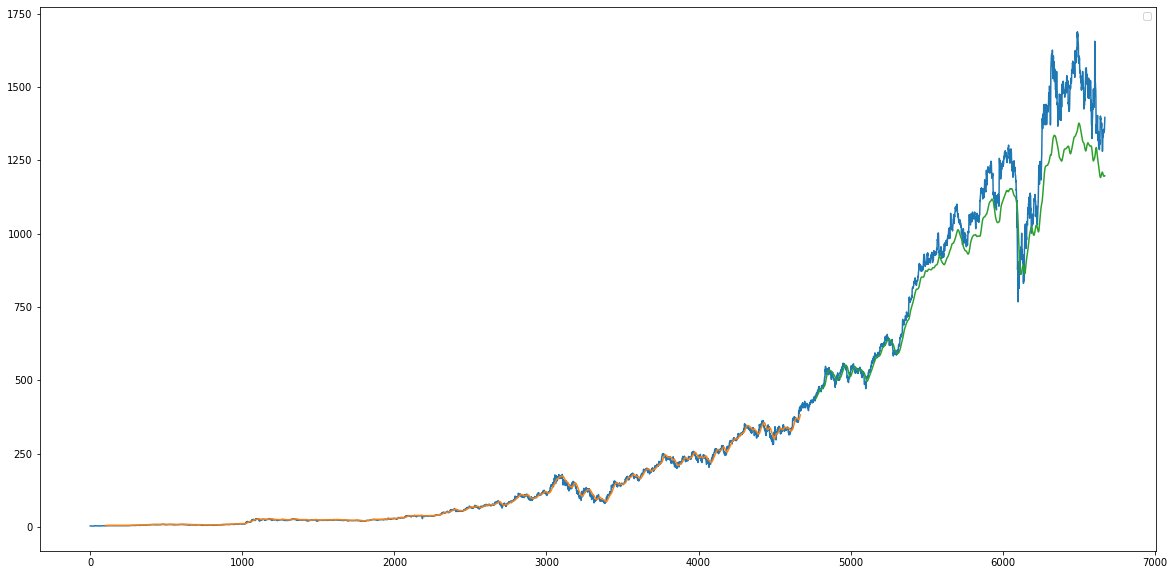

In [95]:
# shift train predictions for plotting
train_predict = scaler.inverse_transform(model.predict(X_train))

look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = y_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend()
plt.show()

### predicting 30 Days future value

In [96]:
x_input=test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [97]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [98]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

#print(lst_output)

In [99]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [100]:
print(scaler.inverse_transform(lst_output))

[[1200.11024323]
 [1200.66987858]
 [1199.87284044]
 [1197.63982702]
 [1194.08531834]
 [1189.41445371]
 [1183.85609264]
 [1177.63145592]
 [1170.93563197]
 [1163.93214928]
 [1156.75136832]
 [1149.49460239]
 [1142.23773596]
 [1135.03444093]
 [1127.92441847]
 [1120.93259485]
 [1114.07485054]
 [1107.3606334 ]
 [1100.79376278]
 [1094.37514326]
 [1088.1030662 ]
 [1081.97411426]
 [1075.98446811]
 [1070.12940381]
 [1064.40459946]
 [1058.8049291 ]
 [1053.32617133]
 [1047.96350172]
 [1042.71289989]
 [1037.57044598]]


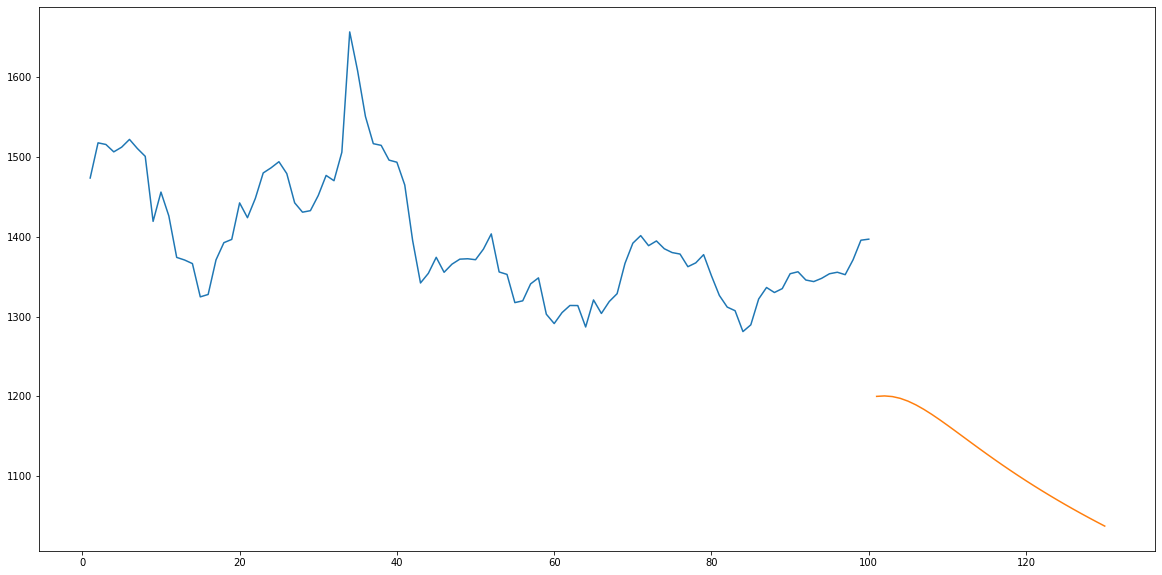

In [101]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

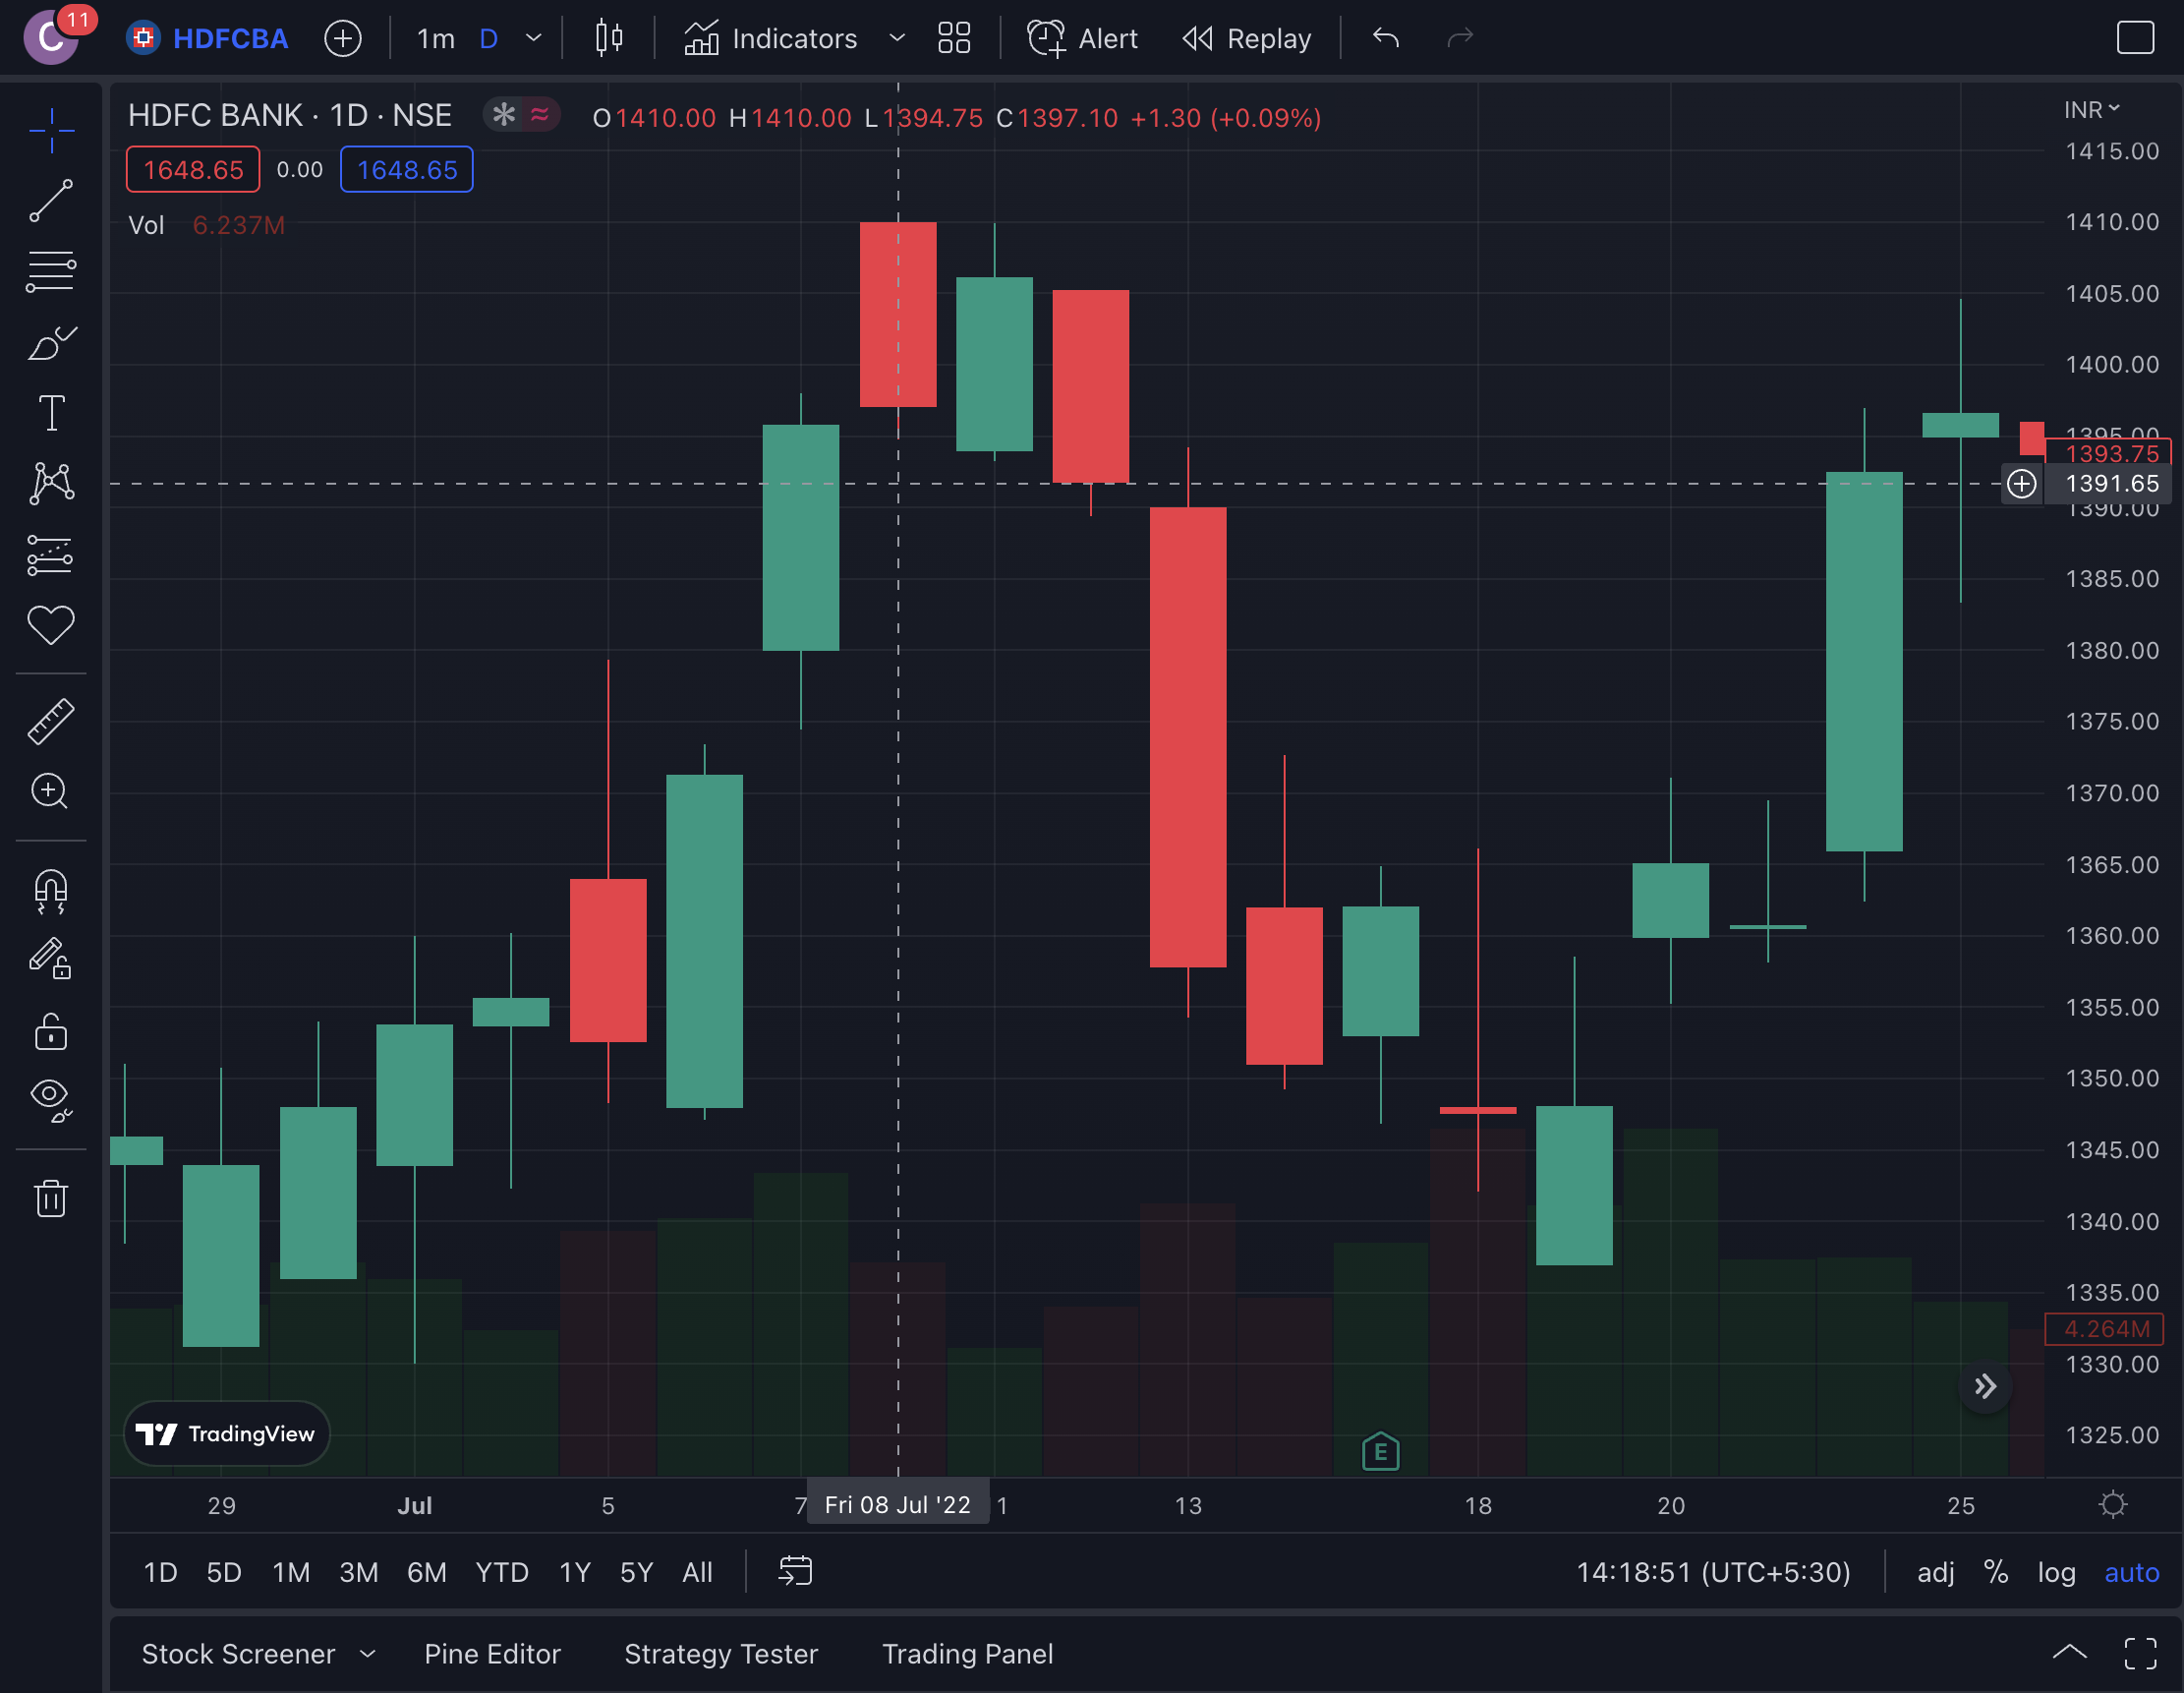